# Plot EOS models

In [1]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import numpy as np
import numpy.typing as npt

from atmodeller.eos.interfaces import RealGas, RealGasProtocol
from atmodeller.eos.holland import get_holland_eos_models
from atmodeller.eos.holley import get_holley_eos_models
from atmodeller.eos.saxena import get_saxena_eos_models

In [2]:
def plot_fugacity_coefficient(eos_model: RealGasProtocol, label:str, ax:Axes, 
    temperature: npt.NDArray, pressure: npt.NDArray) -> None:
    """Plots the fugacity coefficient of an EOS model
    
    Args:
        eos_model: An EOS model
        label: Label for the model
        ax: Axes for plotting
        temperature: Temperature to evaluate the fugacity coefficient in K
        pressure: Pressure to evaluate the fugacity coefficient in bar
    """
    fugacity_coefficient = np.vectorize(eos_model.fugacity_coefficient)
    coefficient = fugacity_coefficient(temperature, pressure)
    ax.plot(pressure, coefficient, label=label)

In [3]:
def plot_eos_collection(eos_collection: dict[str, RealGas], temperature: float) -> Figure:
    """Plots a collection of fugacity coefficients
    
    Args:
        eos_collection: A collection of EOS models
        temperature: Temperature to plot the fugacity coefficient

    Returns:
        Figure handle
    """
    pressure: npt.NDArray = np.linspace(1, 5E4, 100)
    temperature_array: npt.NDArray = temperature * np.ones_like(pressure)

    fig, ax = plt.subplots()

    for species in eos_collection:
        plot_fugacity_coefficient(eos_collection[species], species, ax, temperature_array,
            pressure)

    ax.set_yscale('log')
    ax.set_ylabel(r'Fugacity Coefficient ($\phi = f/P$)')
    ax.set_ylim(1e-2, 1e3)
    ax.set_xlabel('Pressure (bar)')
    ax.set_title(f"Fugacity coefficients at {temperature:.0f} K")
    ax.legend()

    return fig

## Holland models

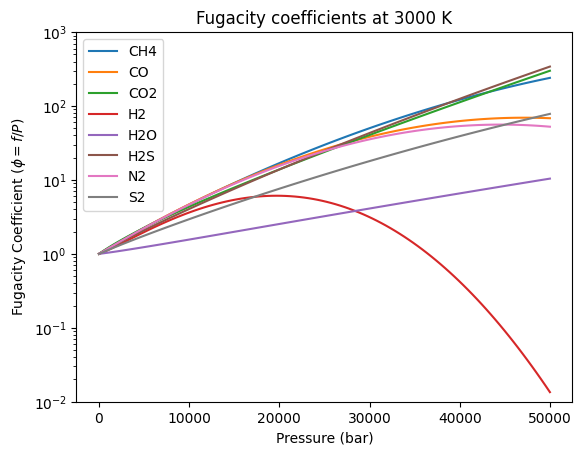

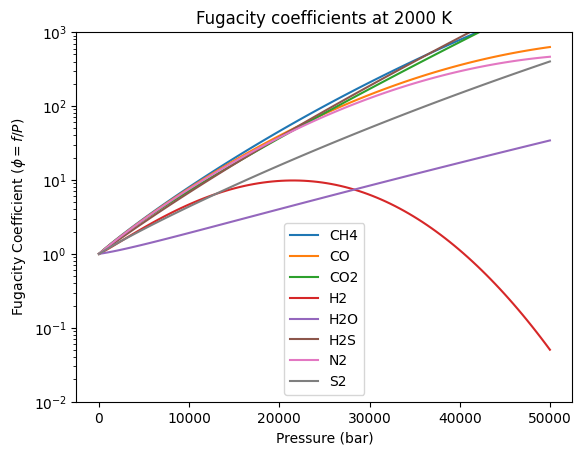

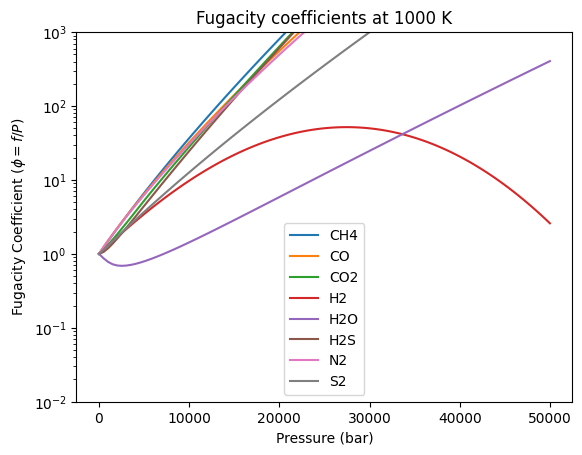

In [4]:
eos_models = get_holland_eos_models()

plot_eos_collection(eos_models, temperature=3000)
plot_eos_collection(eos_models, temperature=2000)
plot_eos_collection(eos_models, temperature=1000);

# Holley models

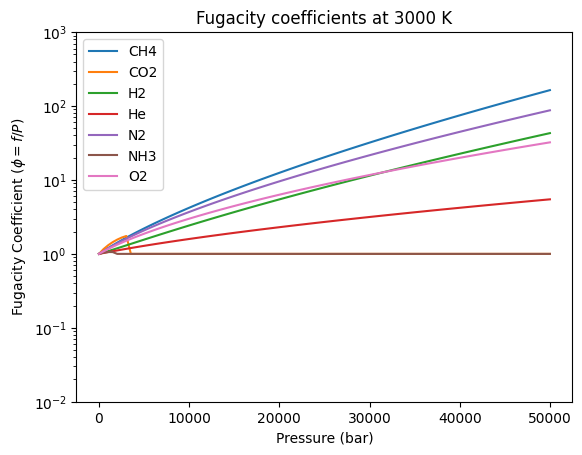

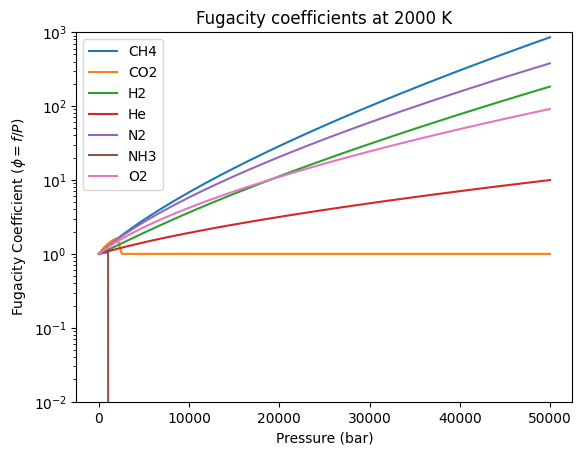

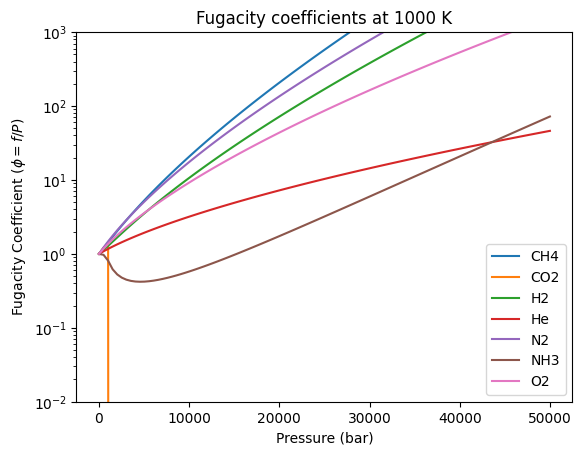

In [5]:
eos_models = get_holley_eos_models()

plot_eos_collection(eos_models, temperature=3000)
plot_eos_collection(eos_models, temperature=2000)
plot_eos_collection(eos_models, temperature=1000);

# Saxena models

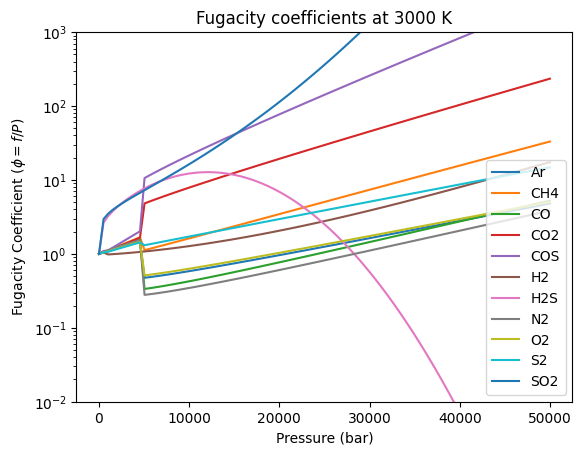

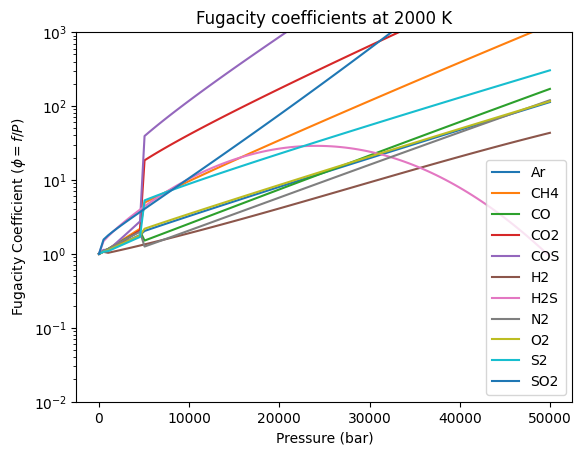

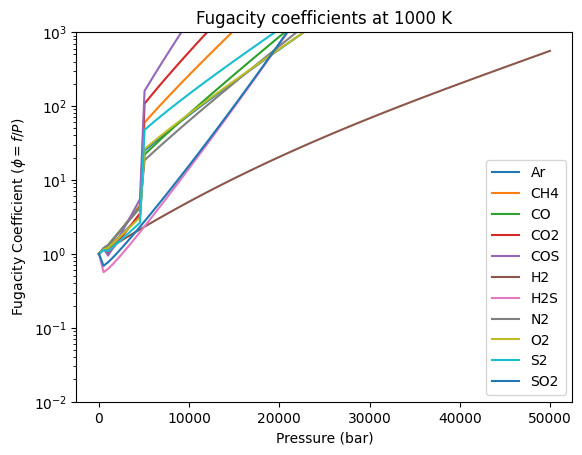

In [6]:
eos_models = get_saxena_eos_models()

plot_eos_collection(eos_models, temperature=3000)
plot_eos_collection(eos_models, temperature=2000)
plot_eos_collection(eos_models, temperature=1000);